In [28]:
# libraries
import os
import pandas as pd 
import seaborn as sns
import numpy as np
import warnings
import random
import cv2
from threading import Thread
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

import keras
import tensorflow as tf

from keras import models, layers
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Conv2D, Input, Dropout, AveragePooling2D, Flatten, MaxPooling2D, Dense, GlobalAveragePooling2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [29]:
images_path = '/kaggle/input/sign-language/KSL-dataset/Images'
test_path = '/kaggle/input/sign-language/KSL-dataset/Test.csv'
train_path = '/kaggle/input/sign-language/KSL-dataset/Train.csv'

# **Exploratory analysis of training dataset**
## 1.**Train data**

In [30]:
train_df = pd.read_csv(train_path)
train_df.head()

,img_IDS,Label
0,ImageID_33HMDMJ3,Temple
1,ImageID_V5POEX4O,Church
2,ImageID_89CCCCW6,Enough/Satisfied
3,ImageID_GNJXOWX5,Me
4,ImageID_7Q9LOP7R,Love


In [31]:
# different classes of images

train_df['Label'].value_counts()

Label
Enough/Satisfied    695
Seat                695
Mosque              695
Temple              694
Church              694
Love                694
Me                  694
You                 694
Friend              694
Name: count, dtype: int64

In [32]:
train_df.shape

(6249, 2)

> Training images constitutes of 6,294 images  with 9 different classes.

**Sample images**

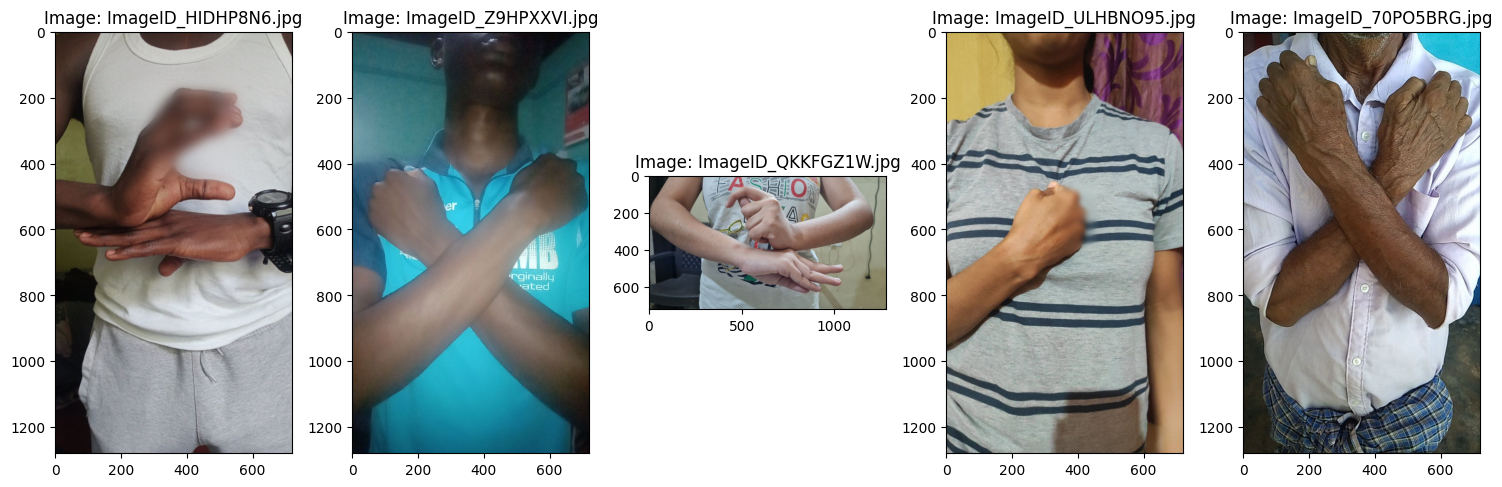

In [33]:
images = [f for f in os.listdir(images_path) if f.endswith(('.jpg'))]
random_images = random.sample(images, 5)

plt.figure(figsize=(15, 10))
for i, image_file in enumerate(random_images):
    img_path = os.path.join(images_path, image_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Image: {image_file}')
    plt.axis('on')
plt.tight_layout()
plt.show()

From the sample visulization, all the images bearing different sign languages have varying sizes. Some images are larger widths or heights than the others.

**Image mapping to corresponding labels**

In [34]:
class KSL:
    def __init__(self, imgs_path, df, LR=1e-4, IMG_SIZE=256, BATCH_SIZE=32, EPOCHS=5):
        self.imgs_path = imgs_path
        self.df = df
        self.LR = LR
        self.IMG_SIZE = IMG_SIZE
        self.BATCH_SIZE = BATCH_SIZE
        self.EPOCHS = EPOCHS
        self.class_mapping = None
    
    def create_mapping(self):
        self.df['img_path'] = self.df['img_IDS'].apply(lambda x: os.path.join(self.imgs_path, f"{x}.jpg"))
        self.class_mapping = {idx: label for idx, label in enumerate(self.df['Label'].unique())}
        self.df['Encoded_Label'] = self.df['Label'].map({label: idx for idx, label in self.class_mapping.items()})
        return self.df
        
#     def create_mapping(self):
#         self.df['img_path'] = self.df['img_IDS'].apply(lambda x: os.path.join(self.imgs_path, f"{x}.jpg"))
#         class_mapping = {label: idx for idx, label in enumerate(self.df['Label'].unique())}
#         self.df['Encoded_Label'] = self.df['Label'].map(class_mapping)
#         return self.df
 
    def crop_center(self, image, crop_size=(600, 600), target_size=(256, 256)):
        h, w, _ = image.shape
        crop_h, crop_w = crop_size

        start_x = (w - crop_w) // 2
        start_y = (h - crop_h) // 2

        cropped_image = image[start_y:start_y + crop_h, start_x:start_x + crop_w]
        resized_image = cv2.resize(cropped_image, target_size)
        
        img_yuv = cv2.cvtColor(resized_image, cv2.COLOR_RGB2YUV)
        img_y_channel = img_yuv[..., 0].astype(np.uint8)
        
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_yuv[..., 0] = clahe.apply(img_y_channel)
        
        equalized_image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return equalized_image
    
    def plot_images_with_labels(self, num_images=5, crop_size=(600, 600), target_size=(256, 256)):
        df = self.create_mapping()
        plt.figure(figsize=(15, 10))
        sample_df = df.sample(num_images)

        for i, (index, row) in enumerate(sample_df.iterrows()):
            img_path = row['img_path']
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            resized_img = self.crop_center(img, crop_size=crop_size, target_size=target_size)
            
            plt.subplot(1, num_images, i + 1)
            plt.imshow(resized_img)
            plt.title(row["Label"])
            plt.axis('on')
        plt.tight_layout()
        plt.show()
        
    def process_ksl_images(self):
        df = self.create_mapping()
        
        def preprocessing_function(img):
            return self.crop_center(img, crop_size=(600, 600), target_size=(self.IMG_SIZE, self.IMG_SIZE))
        
        datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25, preprocessing_function=preprocessing_function)
        
        train_images = datagen.flow_from_dataframe(
            dataframe=df,
            x_col="img_path",
            y_col="Label",
            subset="training",
            batch_size=self.BATCH_SIZE,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=(self.IMG_SIZE, self.IMG_SIZE)
        )
        
        validation_images = datagen.flow_from_dataframe(
            dataframe=df,
            x_col="img_path",
            y_col="Label",
            subset="validation",
            batch_size=self.BATCH_SIZE,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=(self.IMG_SIZE, self.IMG_SIZE)
        )
        
        training_steps = train_images.n // train_images.batch_size
        validation_steps = validation_images.n // validation_images.batch_size
        
        return train_images, validation_images, training_steps, validation_steps
    
    def build_model(self, cnn_model):
        for layer in cnn_model.layers[:10]:
            layer.trainable = False
        x = cnn_model.output
        x = AveragePooling2D(pool_size=(4, 4))(x)
        x = Flatten(name='flatten')(x)
        x = Dense(9, activation='softmax')(x)
        model = tf.keras.models.Model(inputs=cnn_model.input, outputs=x)
        model.compile(optimizer=Adam(learning_rate=self.LR), loss='categorical_crossentropy', metrics=['accuracy'])
        return model
        
    def build_resnet50(self):
        resnet_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        return self.build_model(resnet_model)

    def build_inceptionv3(self):
        inception_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        return self.build_model(inception_model)

    def build_inception_resnet(self):
        inception_resnet = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        return self.build_model(inception_resnet)

    def build_vgg16(self):
        vgg16_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        return self.build_model(vgg16_model)

    def build_vgg19(self):
        vgg19_model = VGG19(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        return self.build_model(vgg19_model)

    def build_densenet(self):
        densenet_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        return self.build_model(densenet_model)
    
    def train_models(self):
        train_images, validation_images, training_steps, validation_steps = self.process_ksl_images()
        
        model_funcs = {
        'ResNet50': self.build_resnet50(),
#         'InceptionV3': self.build_inceptionv3(),
#         'InceptionResNetV2': self.build_inception_resnet(),
#         'VGG16': self.build_vgg16(),
#         'VGG19': self.build_vgg19(),
        'DenseNet121': self.build_densenet()
        }

        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.00001)

        histories = {}
        y_true = []
        y_pred = {}
        
        for model_name, cnn_model in model_funcs.items():
            print(f"Running {model_name}")
            history = cnn_model.fit(
                train_images,
                steps_per_epoch=training_steps,
                validation_data=validation_images,
                validation_steps=validation_steps,
                epochs=self.EPOCHS,
                callbacks=[reduce_lr]
            )
            histories[model_name] = history
            y_pred[model_name] = cnn_model.predict(validation_images)
            if not y_true:
                y_true = validation_images.classes
            
        return histories, y_true, y_pred
    
    def plot_precision_recall(self, y_true, y_pred):
        # Binarize the output labels for multi-class precision-recall curve calculation
        n_classes = len(np.unique(y_true))  # Should be 9 in your case
#         print("Number of classes:".format(n_classes))
        y_true_binarized = label_binarize(y_true, classes=np.arange(n_classes))
        
        for model_name, y_prob in y_pred.items():
            plt.figure(figsize=(10, 8))
            
            # Iterate over each class to plot the precision-recall curve
            for i in range(n_classes):
                precision, recall, _ = precision_recall_curve(y_true_binarized[:, i], y_prob[:, i])
                plt.plot(recall, precision, lw=2, label=f'{self.class_mapping[i]} (AP={average_precision_score(y_true_binarized[:, i], y_prob[:, i]):.2f})')
            
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title(f'Precision-Recall Curve for {model_name}')
            plt.legend(loc='lower left')
            plt.show()
    
    def plot_metrics(self, histories):
        for model_name, history in histories.items():
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 2, 1)
            plt.plot(history.history['accuracy'], label='train_accuracy')
            plt.plot(history.history['val_accuracy'], label='val_accuracy')
            plt.title(f'{model_name} Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.plot(history.history['loss'], label='train_loss')
            plt.plot(history.history['val_loss'], label='val_loss')
            plt.title(f'{model_name} Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()

            plt.show()



In [35]:
ksl = KSL(imgs_path=images_path, df=train_df)

In [36]:
histories, y_true, y_pred = ksl.train_models()

Found 4687 validated image filenames belonging to 9 classes.
Found 1562 validated image filenames belonging to 9 classes.
Running ResNet50
Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 119s 473ms/step - accuracy: 0.4093 - loss: 1.7386 - val_accuracy: 0.1237 - val_loss: 2.3091 - learning_rate: 1.0000e-04
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6562 - loss: 1.0330 - val_accuracy: 0.0385 - val_loss: 2.4127 - learning_rate: 1.0000e-04
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 50s 335ms/step - accuracy: 0.9042 - loss: 0.3195 - val_accuracy: 0.1204 - val_loss: 2.3650 - learning_rate: 1.0000e-04
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.7812 - loss: 0.5643 - val_accuracy: 0.1154 - val_loss: 2.1958 - learning_rate: 1.0000e-04
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 48s 317ms/step - accuracy: 0.9858 - loss: 0.0859 - val_accuracy: 0.1224 - val_loss: 2.3864 - learning_rate: 2.0000e-05
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step
Running DenseNet121
Epoch 1/5
 

W0000 00:00:1725284779.445908     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/146 ━━━━━━━━━━━━━━━━━━━━ 224s 758ms/step - accuracy: 0.4136 - loss: 1.7130 - val_accuracy: 0.6562 - val_loss: 0.9869 - learning_rate: 1.0000e-04
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7188 - loss: 0.7517 - val_accuracy: 0.6538 - val_loss: 1.0229 - learning_rate: 1.0000e-04
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 51s 337ms/step - accuracy: 0.9243 - loss: 0.2678 - val_accuracy: 0.7109 - val_loss: 0.8263 - learning_rate: 1.0000e-04
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.9062 - loss: 0.3440 - val_accuracy: 0.7692 - val_loss: 0.9065 - learning_rate: 1.0000e-04
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 50s 328ms/step - accuracy: 0.9977 - loss: 0.0628 - val_accuracy: 0.7663 - val_loss: 0.6586 - learning_rate: 1.0000e-04
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 408ms/step


Number of classes:


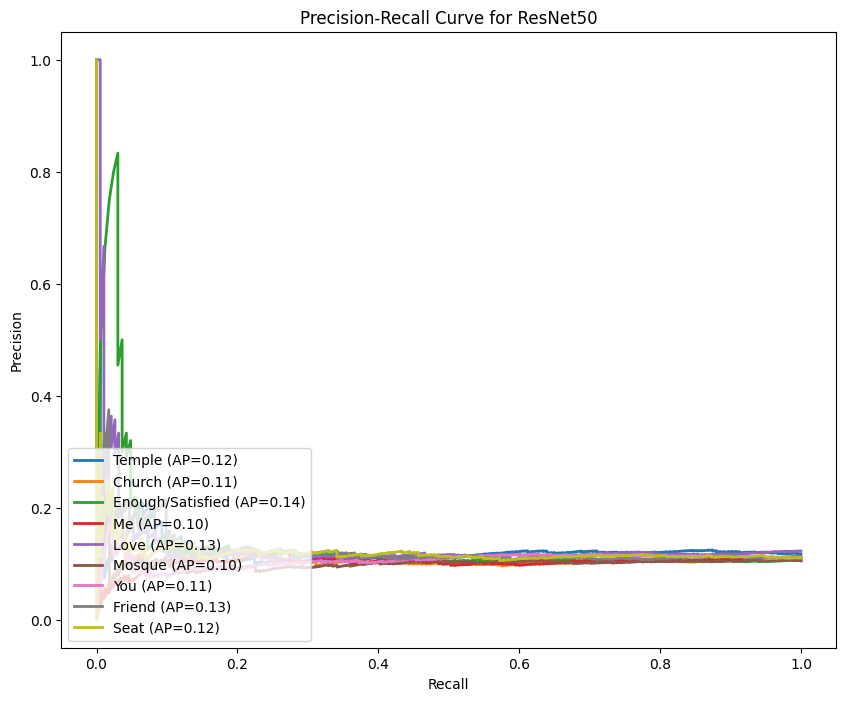

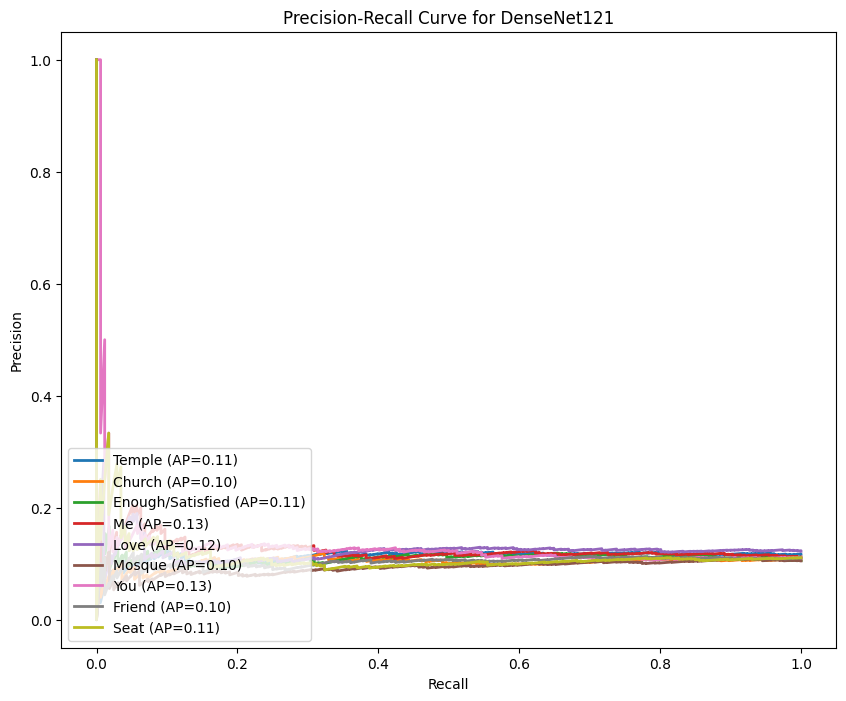

In [37]:
ksl.plot_precision_recall(y_true, y_pred)

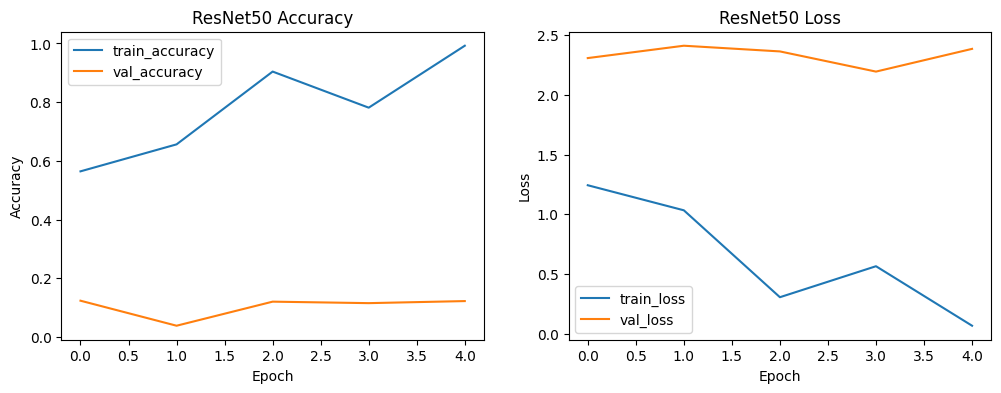

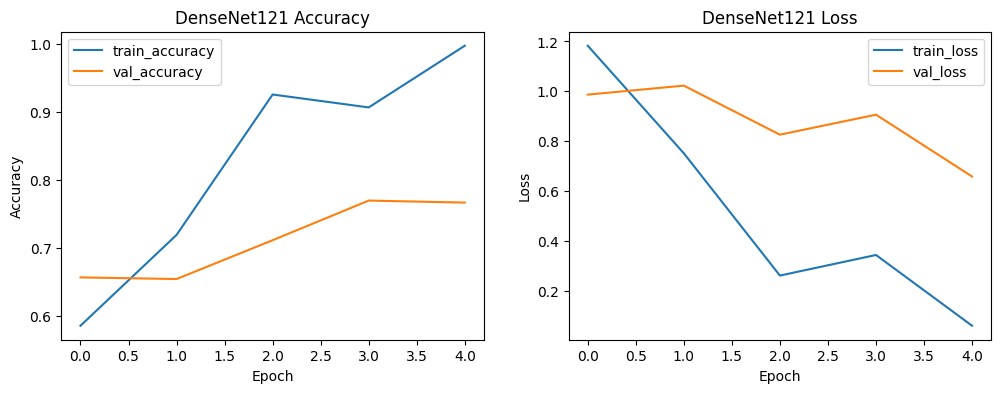

In [38]:
ksl.plot_metrics(histories)